In [1]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumRings


from copy import deepcopy


def remove_atom_mapping_from_reaction_smiles(reaction_smiles):
    """
    Remove atom mapping from a reaction SMILES string.
    
    Parameters:
    - reaction_smiles (str): A reaction SMILES string with atom mapping.
    
    Returns:
    - str: A reaction SMILES string without atom mapping.
    """
    # Split the reaction SMILES into its components (reactants, agents, products)
    parts = reaction_smiles.split('>>')
    
    # Remove atom mapping from each part
    cleaned_parts = [Chem.CanonSmiles(re.sub(r":\d+", "", part)) for part in parts]
    
    # Concatenate the cleaned parts back into a reaction SMILES string
    cleaned_reaction_smiles = '>>'.join(cleaned_parts)
    
    return cleaned_reaction_smiles



def calculate_chemical_properties(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Initialize RDKit molecule objects from SMILES
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        if reactant_mol is not None and product_mol is not None:
            # Calculate carbon difference
            num_carbon_reactants = sum([atom.GetAtomicNum() == 6 for atom in reactant_mol.GetAtoms()])
            num_carbon_products = sum([atom.GetAtomicNum() == 6 for atom in product_mol.GetAtoms()])
            entry['carbon_difference'] = abs(num_carbon_reactants - num_carbon_products)
            
            # Calculate total number of carbons
            entry['total_carbons'] = num_carbon_reactants + num_carbon_products

            # Calculate total number of bonds
            entry['total_bonds'] = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())

            # Calculate total number of rings
            entry['total_rings'] = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        else:
            entry['carbon_difference'] = "Invalid SMILES"
            entry['total_carbons'] = "Invalid SMILES"
            entry['total_bonds'] = "Invalid SMILES"
            entry['total_rings'] = "Invalid SMILES"



        # Process for fragment count calculation
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count

    return updated_list




def count_boundary_atoms_products_and_calculate_changes(list_of_dicts):
    for item in list_of_dicts:
        count = 0  # Initialize count for boundary_atoms_products
        # Initialize variables for bond and ring changes
        bond_change = 0
        ring_change = 0
        
        if 'boundary_atoms_products' in item and item['boundary_atoms_products']:
            for i in item['boundary_atoms_products']:
                if isinstance(i, dict):
                    count += 1
                elif isinstance(i, list):
                    for j in i:
                        if isinstance(j, dict):
                            count += 1
        
        # Split new_reactions into reactant and product SMILES and calculate changes
        
        reactant_product = item['new_reaction'].split('>>')
        if len(reactant_product) == 2:  # Ensure there are both reactant and product
            reactant_smiles, product_smiles = reactant_product
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
            product_mol = Chem.MolFromSmiles(product_smiles)
            
            if reactant_mol and product_mol:
                # Calculate bond change
                bond_change = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())
                # Calculate ring change
                ring_change = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        
        # Add calculated values to the dictionary
        item['num_boundary'] = count
        item['bond_change_merge'] = bond_change
        item['ring_change_merge'] = ring_change

    return list_of_dicts

In [2]:
import pandas as pd
import pandas as pd
from SynRBL.rsmi_utils import load_database
from IPython.display import clear_output
def process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=True):
    """
    Processes and combines datasets from specified paths.

    Parameters:
    - list_data (list): List of dataset names.
    - pipeline_path (str): Path to the pipeline files.
    - data_path (str): Path to the data files.

    Returns:
    - pd.DataFrame: Combined DataFrame of all processed datasets.
    """
    data_all = pd.DataFrame()
    
    for data_name in list_data:
        # Load dataset CSV and adjust columns
        data_csv_path = f'{pipeline_path}/Validation/Analysis/SynRBL - {data_name}.csv'
        data = pd.read_csv(data_csv_path).drop(['Note'], axis=1)
        #print(data.shape)
        data.loc[data['Result'] == 'CONSIDER', 'Result'] = False
        data.loc[data['Result'] == 'FALSE', 'Result'] = False
        data.loc[data['Result'] == 'TRUE', 'Result'] = True
        #data['Result'] =

        # Load and process additional data
        merge_data_path = f'{data_path}/Validation_set/{data_name}/MCS/MCS_Impute.json.gz'
        mcs_data_path = f'{data_path}/Validation_set/{data_name}/mcs_based_reactions.json.gz'
        
        merge_data = load_database(merge_data_path)
        #print(len(merge_data))
        merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
        mcs_data = load_database(mcs_data_path)
        id = [value['R-id'] for value in merge_data]
        mcs_data = [value for value in mcs_data if value['R-id'] in id]
        mcs_data = calculate_chemical_properties(mcs_data)
        #print(len(mcs_data))
        #clear_output(wait=False)
        
        # Combine data
        combined_data = pd.concat([
            pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
            data,
            pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge']],
        ], axis=1)
        #print(combined_data.isnull().sum().sum())
        combined_data.loc[(combined_data['mcs_carbon_balanced'] == False) & (combined_data['Result'] == True), 'Result']=False
        if remove_undetected:
            combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
        
        data_all = pd.concat([data_all, combined_data], axis=0)
    data_all = data_all.reset_index(drop=True)
    unnamed_columns = [col for col in data_all.columns if 'Unnamed' in col]
    data_all = data_all.drop(unnamed_columns, axis=1)

    return data_all


list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'

data_total = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False)


[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not removing hydrogen atom without neighbors
[09:18:07] WARNING: not r

In [3]:
from drfp import DrfpEncoder
rxn_smiles=data_total['reactions'].tolist()
fps = DrfpEncoder.encode(rxn_smiles)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipelinelit
X= fps
y = data_total['Result']

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
steps = [('scaler', MinMaxScaler()), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.20      0.28        87
           1       0.83      0.95      0.89       364

    accuracy                           0.81       451
   macro avg       0.67      0.57      0.58       451
weighted avg       0.77      0.81      0.77       451



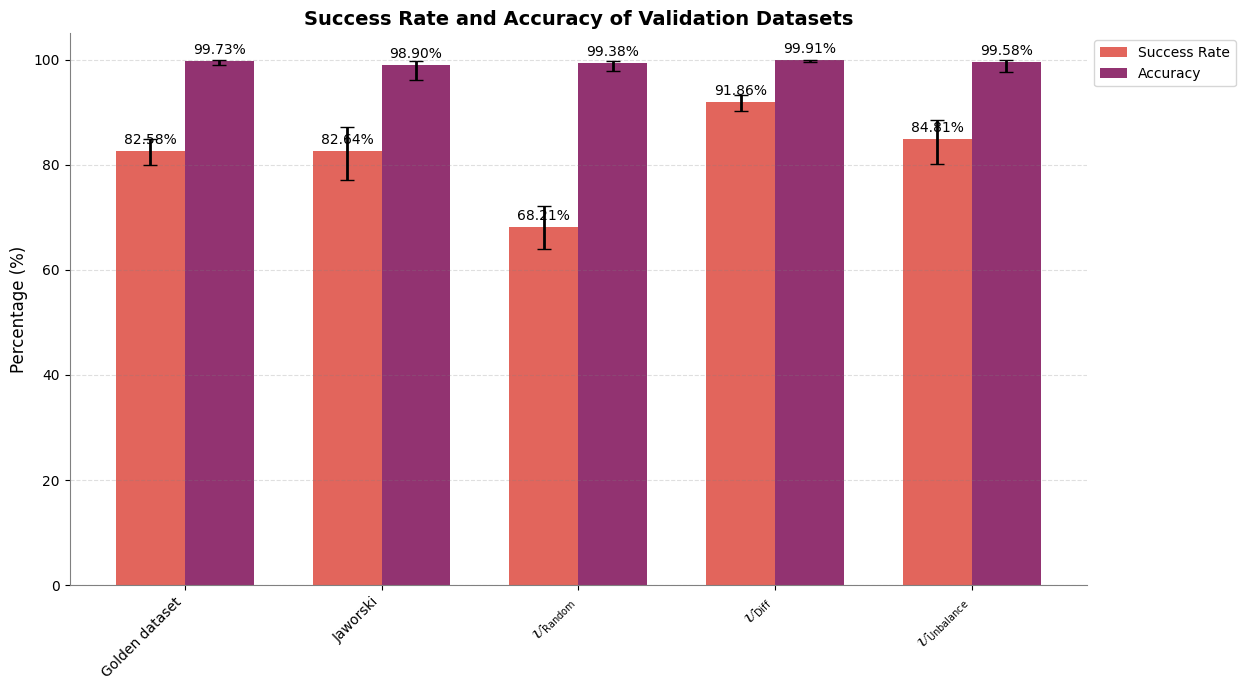

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])

# Successes and accuracies
successes = np.round(unbalance * success_rate).astype(int)
accuracies = np.round(successes * accuracy).astype(int)

# Confidence intervals
confint_success = proportion_confint(successes, unbalance, method='wilson')
confint_accuracy = proportion_confint(accuracies, successes, method='wilson')

# Error margins
error_success = np.abs(np.vstack(confint_success) - success_rate)
error_accuracy = np.abs(np.vstack(confint_accuracy) - accuracy)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Colormap
cmap = plt.get_cmap('flare', 256)
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)

# Plotting
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Labels and styling
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Annotation function
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
#plt.savefig('rule_based.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


In [6]:
import pandas as pd
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])
data = pd.DataFrame({'Dataset': datasets, 'Success Rate': success_rate, 'Accuracy': accuracy, 'Unbalance': unbalance})

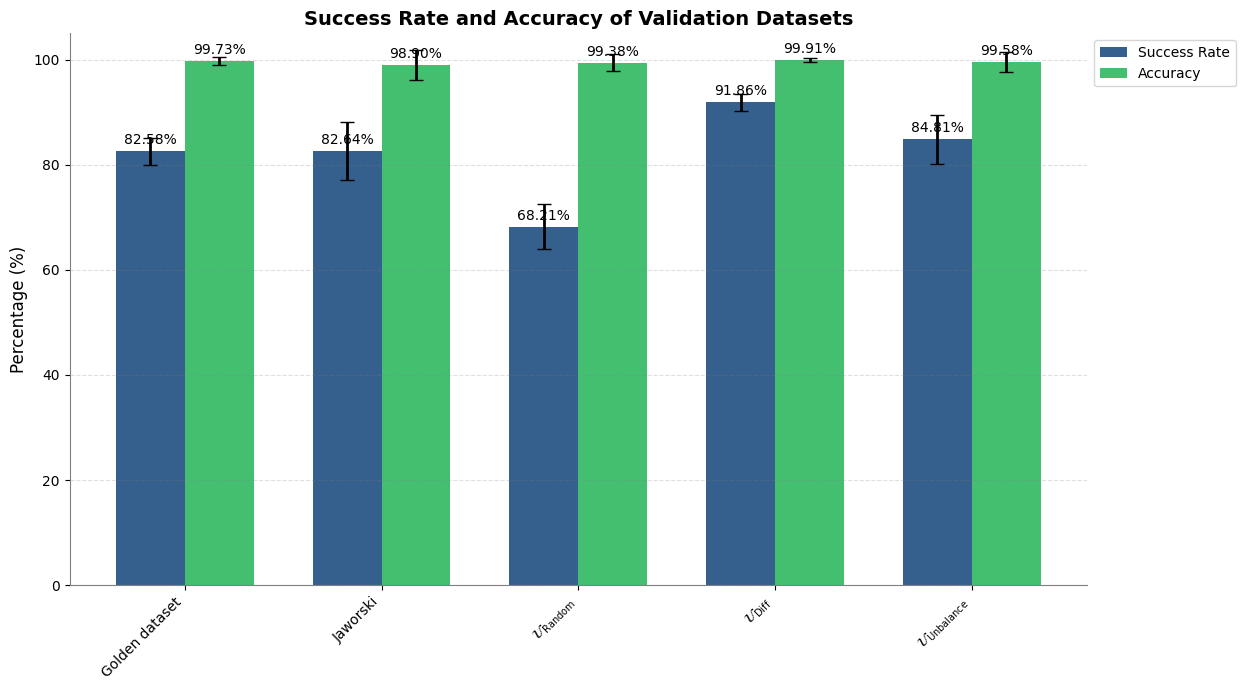

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

def plot_success_accuracy(df):
    # Assuming df structure: ['Dataset', 'Success Rate', 'Accuracy', 'Unbalance']
    
    # Extracting data
    datasets = df['Dataset']
    success_rate = df['Success Rate']
    accuracy = df['Accuracy']
    unbalance = df['Unbalance']
    
    # Calculations
    successes = np.round(unbalance * success_rate).astype(int)
    accuracies = np.round(successes * accuracy).astype(int)
    
    # Confidence intervals
    confint_success = proportion_confint(successes, unbalance, method='wilson')
    confint_accuracy = proportion_confint(accuracies, successes, method='wilson')
    
    # Error margins
    # Error margins for success
    lower_bound_success = confint_success[0]  # Lower bound of the confidence interval for success
    upper_bound_success = confint_success[1]  # Upper bound of the confidence interval for success
    # Calculating the distance from the mean to both bounds, choosing the max distance as the error
    error_success = np.maximum(success_rate - lower_bound_success, upper_bound_success - success_rate)

    # Error margins for accuracy
    lower_bound_accuracy = confint_accuracy[0]  # Lower bound of the confidence interval for accuracy
    upper_bound_accuracy = confint_accuracy[1]  # Upper bound of the confidence interval for accuracy
    # Calculating the distance from the mean to both bounds, choosing the max distance as the error
    error_accuracy = np.maximum(accuracy - lower_bound_accuracy, upper_bound_accuracy - accuracy)

    
    bar_width = 0.35
    index = np.arange(len(datasets))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Assuming 'flare' is available or use an alternative like 'viridis'
    cmap = plt.get_cmap('viridis')
    color_for_success_rate = cmap(0.3)
    color_for_accuracy = cmap(0.7)
    
    # Plotting
    bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success.T*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
    bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy.T*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})
    
    # Labels and styling
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
    plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 105)
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    # Annotation function
    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    annotate_bars(bars1)
    annotate_bars(bars2)
    
    # Legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)
    plt.show()

# Example usage with a DataFrame
data = {
    'Dataset': ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"],
    'Success Rate': [0.8258, 0.8264, 0.6821, 0.9186, 0.8481],
    'Accuracy': [0.9973, 0.9890, 0.9938, 0.9991, 0.9958],
    'Unbalance': [913, 219, 475, 1253, 283]
}
df = pd.DataFrame(data)

# Call the function with the DataFrame
plot_success_accuracy(df)


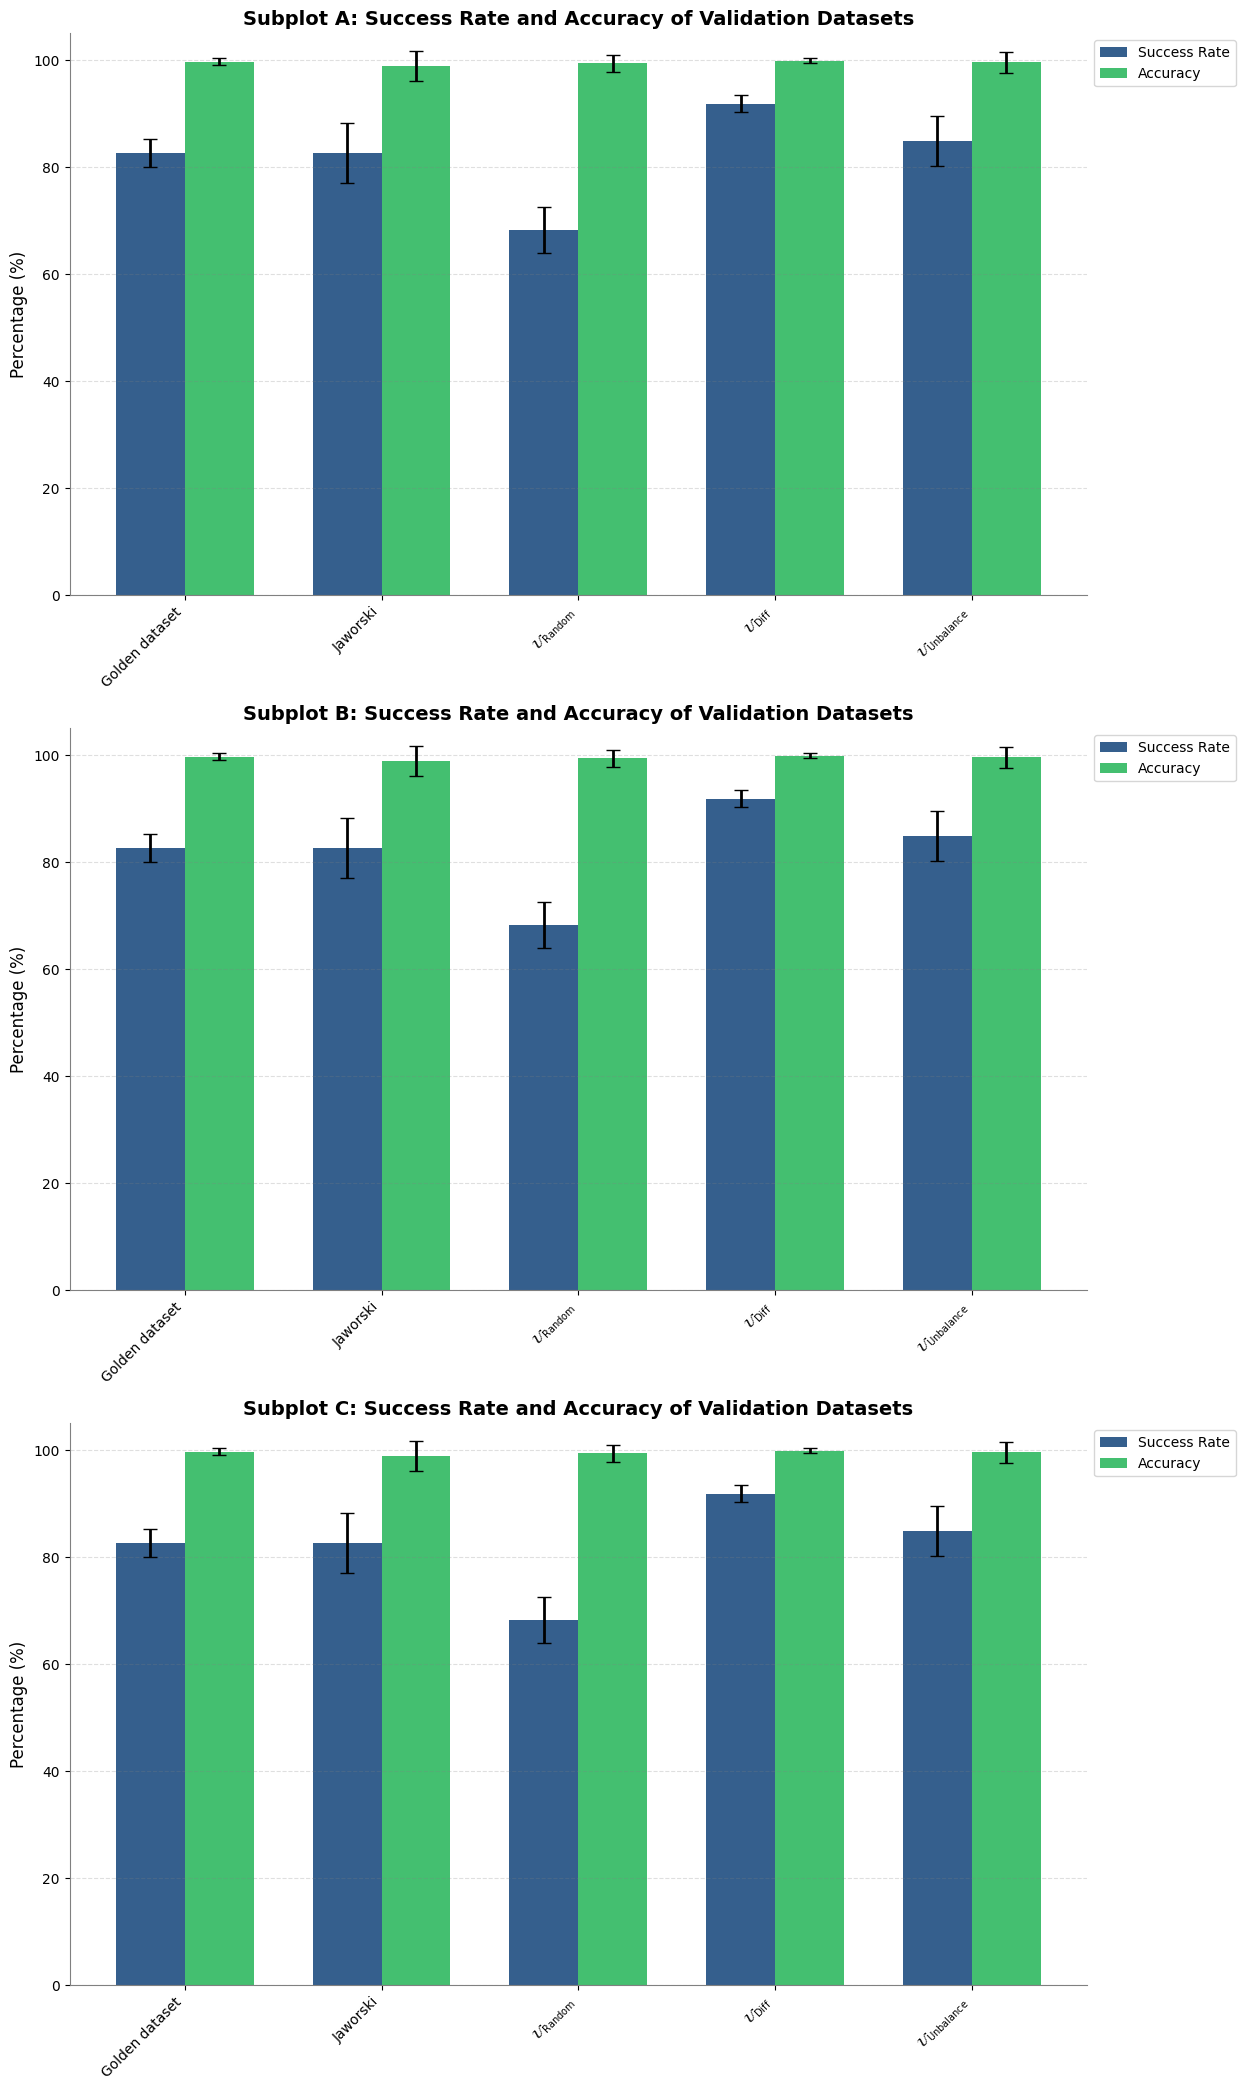

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
def plot_success_accuracy_multiple_dfs(dfs):
    # Initialize the figure with 3 subplots arranged vertically (3x1)
    fig, axs = plt.subplots(len(dfs), 1, figsize=(14, 21))
    
    # Assuming 'viridis' colormap is available
    cmap = plt.get_cmap('viridis')
    color_for_success_rate = cmap(0.3)
    color_for_accuracy = cmap(0.7)
    
    # Labels for each subplot
    subplot_labels = ['A', 'B', 'C']
    
    for i, df in enumerate(dfs):
        ax = axs[i]  # Select the subplot for the current DataFrame
        datasets = df['Dataset']
        success_rate = df['Success Rate']
        accuracy = df['Accuracy']
        unbalance = df['Unbalance']
        
        # Calculations
        successes = np.round(unbalance * success_rate).astype(int)
        accuracies = np.round(successes * accuracy).astype(int)
        
        # Confidence intervals
        confint_success = proportion_confint(successes, unbalance, method='wilson')
        confint_accuracy = proportion_confint(accuracies, successes, method='wilson')
        
        # Error margins
        error_success = np.maximum(success_rate - confint_success[0], confint_success[1] - success_rate)
        error_accuracy = np.maximum(accuracy - confint_accuracy[0], confint_accuracy[1] - accuracy)
        
        bar_width = 0.35
        index = np.arange(len(datasets))
        
        # Plotting
        ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
        ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})
        
        # Subplot title with label
        ax.set_title(f'Subplot {subplot_labels[i]}: Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
        
        # Setting x-axis labels
        ax.set_xticks(index)
        ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)
        ax.set_ylim(0, 105)
        
        # Styling
        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.set_ylabel('Percentage (%)', fontsize=12)
        
        # Adding a legend to each subplot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)
    plt.show()

# Example usage with three DataFrames
df1 = pd.DataFrame({
    'Dataset': ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"],
    'Success Rate': [0.8258, 0.8264, 0.6821, 0.9186, 0.8481],
    'Accuracy': [0.9973, 0.9890, 0.9938, 0.9991, 0.9958],
    'Unbalance': [913, 219, 475, 1253, 283]
})
df2 = df1.copy()  # Assuming similar structure for simplicity; replace with your actual df2
df3 = df1.copy()  # Assuming similar structure for simplicity; replace with your actual df3

# Call the function with a list of DataFrames
plot_success_accuracy_multiple_dfs([df1, df2, df3])


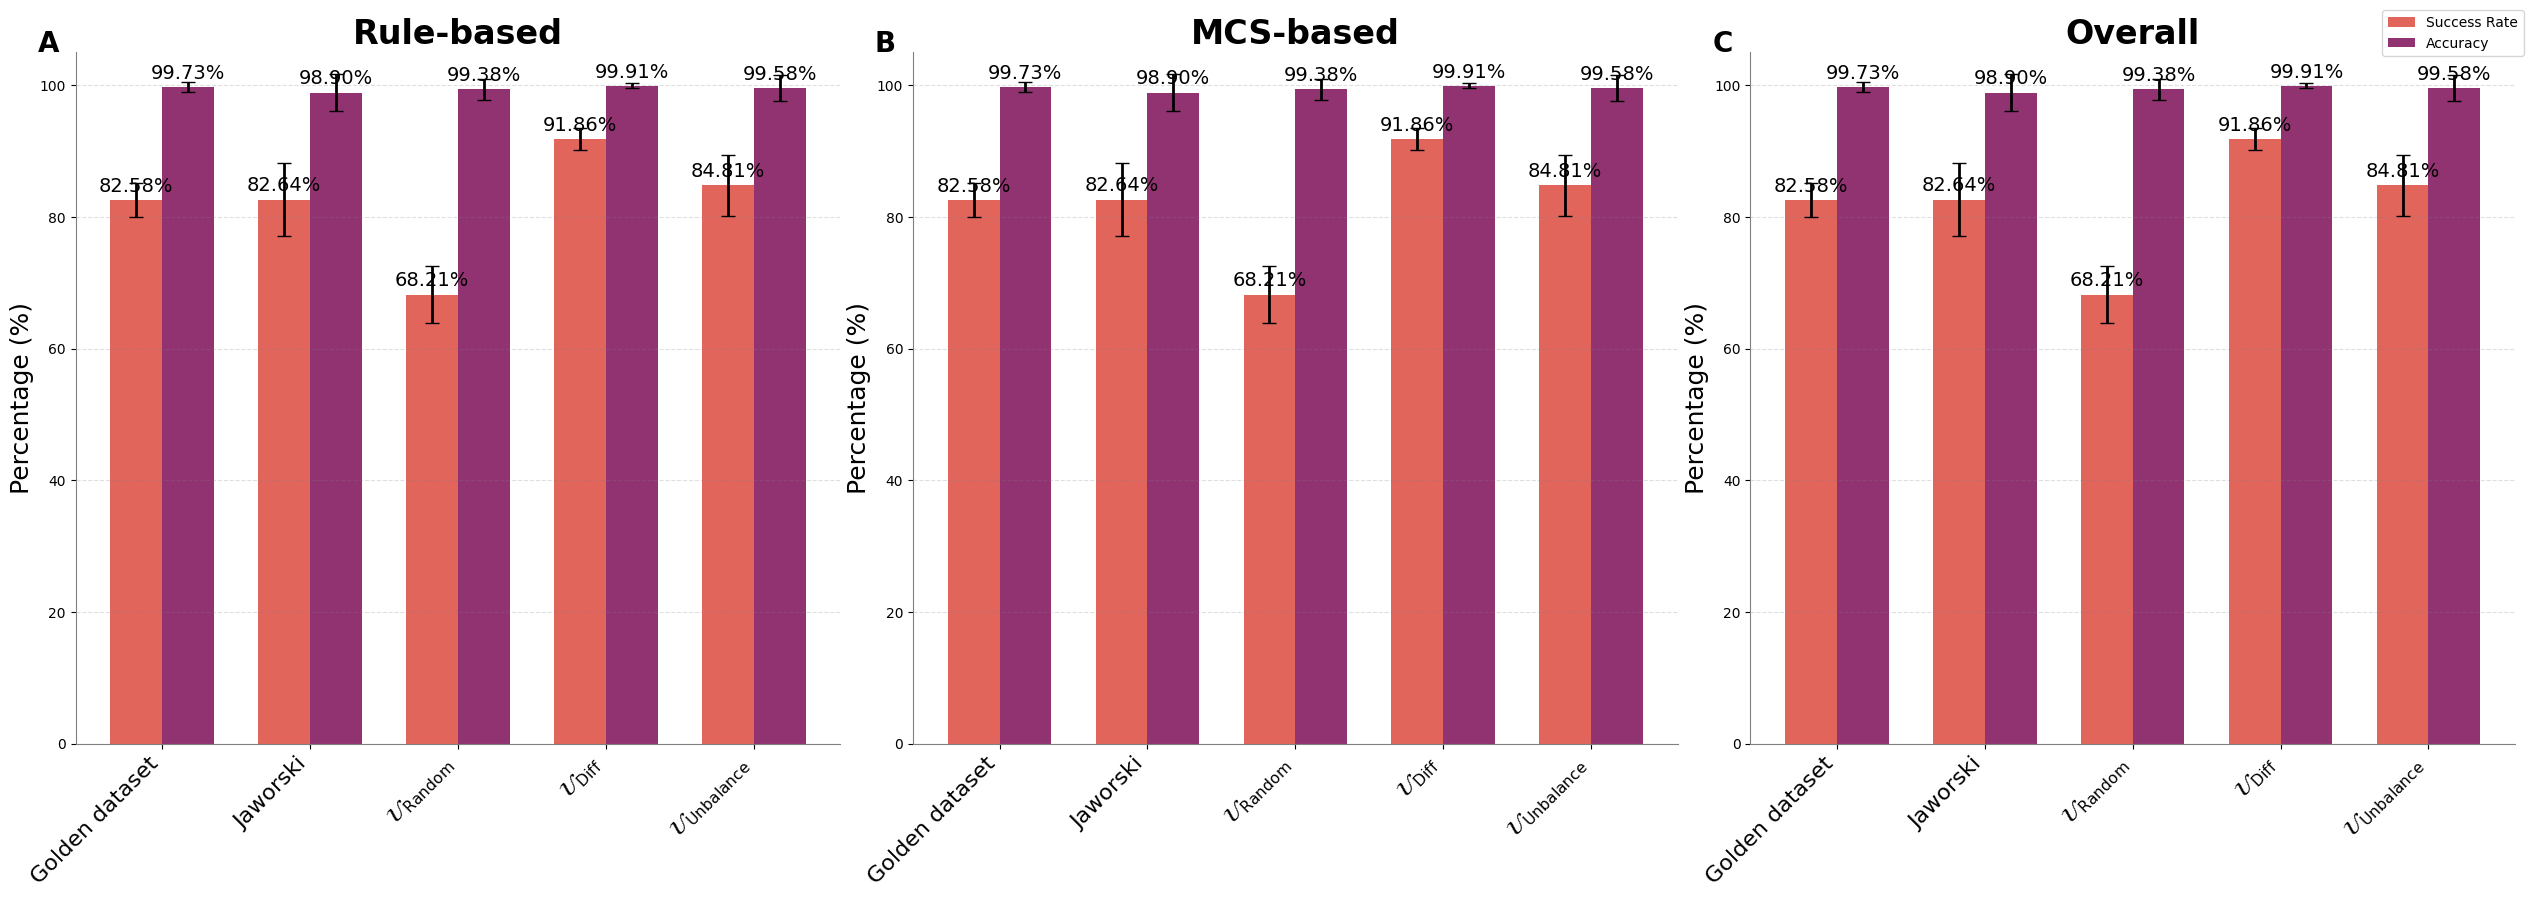

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

def plot_success_accuracy_multiple(dfs, layout='vertical', show_values=False, 
                                   title_name = ['Rule-based', 'MCS-based', 'Overall']):
    if layout not in ['vertical', 'horizontal']:
        raise ValueError("Layout must be 'vertical' or 'horizontal'")
    
    if layout == 'vertical':
        fig, axs = plt.subplots(3, 1, figsize=(14, 21))  # Adjusted for vertical layout
    else:
        fig, axs = plt.subplots(1, 3, figsize=(28, 9))  # Adjusted for horizontal layout
    
    labels = ['A', 'B', 'C']  # Labels for each subplot
    for i, df in enumerate(dfs):
        ax = axs[i] if layout == 'vertical' else axs[i]
        datasets = df['Dataset']
        success_rate = df['Success Rate']
        accuracy = df['Accuracy']
        unbalance = df['Unbalance']
        
        successes = np.round(unbalance * success_rate).astype(int)
        accuracies = np.round(successes * accuracy).astype(int)
        
        confint_success = proportion_confint(successes, unbalance, method='wilson')
        confint_accuracy = proportion_confint(accuracies, successes, method='wilson')
        
        error_success = np.maximum(success_rate - confint_success[0], confint_success[1] - success_rate)
        error_accuracy = np.maximum(accuracy - confint_accuracy[0], confint_accuracy[1] - accuracy)
        
        bar_width = 0.35
        index = np.arange(len(datasets))
        
        cmap = plt.get_cmap('flare')
        color_for_success_rate = cmap(0.3)
        color_for_accuracy = cmap(0.7)
        
        bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success.T*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
        bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy.T*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})
        
        ax.set_ylabel('Percentage (%)', fontsize=18)
        ax.set_xticks(index)
        ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=16)
        ax.set_ylim(0, 105)
        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.set_title(f'{title_name[i]}', fontsize=24, fontweight='bold')
        ax.text(-0.05, 1.0, labels[i], transform=ax.transAxes, size=20, weight='bold')
        
        if show_values:
            annotate_bars(bars1, ax)
            annotate_bars(bars2, ax)
        
    fig.legend(['Success Rate', 'Accuracy'], loc='upper left', bbox_to_anchor=(0.85, 1), fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(right=0.78 if layout == 'vertical' else 0.9)
    plt.show()

def annotate_bars(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)

# Example usage with a list of DataFrames
df1 = pd.DataFrame(data)  # Assuming 'data' is already defined as in your previous example
df2 = df1.copy()
df3 = df1.copy()

# Call the function with the DataFrames, layout, and show_values option
plot_success_accuracy_multiple([df1, df2, df3], layout='horizontal', show_values=True)


In [ ]:

# Call the function with the DataFrames, layout, and show_values option
plot_success_accuracy_multiple([df1, df2, df3], layout='horizontal', show_values=True)

In [39]:
import seaborn as sns

# Assuming 'df' is your DataFrame and it has a 'Year' column for faceting
g = sns.catplot(x='Dataset', y='Value', hue='Metric', col='Year', data=df, kind='bar', height=4, aspect=1)
g.set_axis_labels("Dataset", "Percentage")
g.set_titles("Year: {col_name}")
g.despine(left=True)


ValueError: Could not interpret value `Value` for `y`. An entry with this name does not appear in `data`.

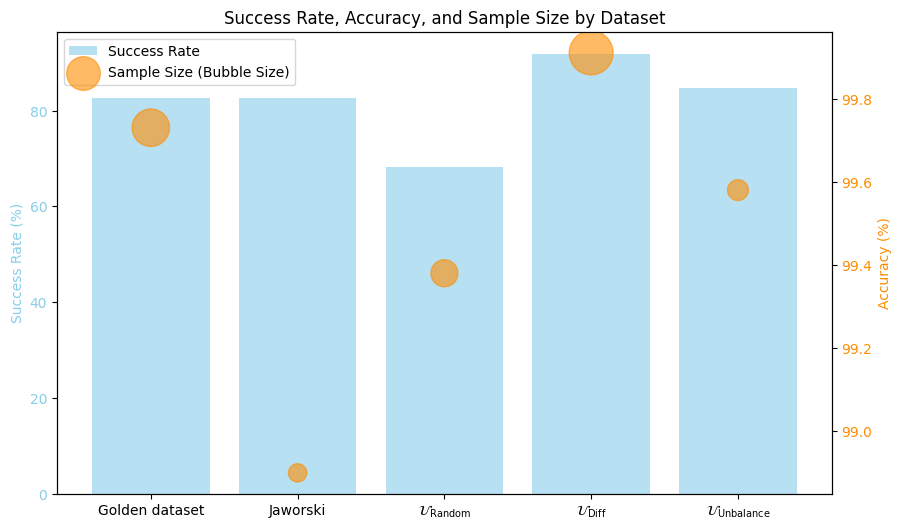

In [38]:
plot_with_bubble_overlay(df)